# <span style="color:red">For NeurIPS 2022 Reviewers</span>

The original version of this notebook is publicly available at [here](https://github.com/anishathalye/obfuscated-gradients/blob/master/inputtransformations/crop.ipynb).

The first part remains unchanged, please feel free to scroll down.

**<span style="color:red">The second part is our new <a href="#ablation">Ablation Study</a> showing that PGD already works without EOT.</span>**

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import warnings
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.logging.set_verbosity(tf.logging.ERROR)
import numpy as np
import inceptionv3
from utils import *
from defense import *

In [2]:
sess = tf.Session()

# Image and target class

Choose what you want here.

In [3]:
orig = load_image('cat.jpg')
TARGET = 924 # guacamole

# Classifier

In [4]:
x = tf.placeholder(tf.float32, (299, 299, 3))
x_expanded = tf.expand_dims(x, axis=0)
logits, preds = inceptionv3.model(sess, x_expanded)

In [5]:
probs = tf.nn.softmax(logits)
classify = make_classify(sess, x, probs)

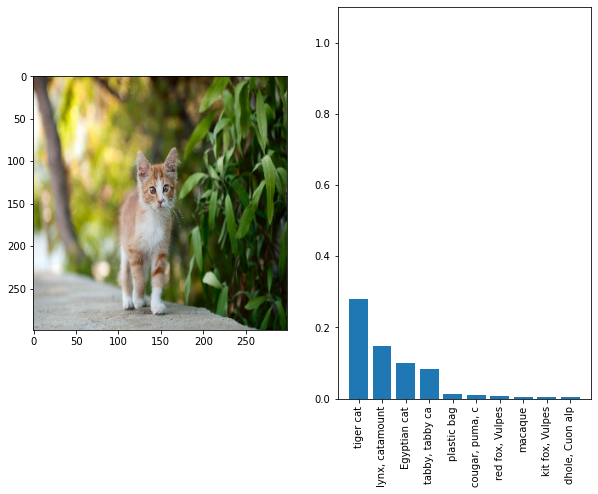

In [6]:
classify(orig, target_class=TARGET)

# Failed attack (attempting to transfer)

In [7]:
l2_x = tf.placeholder(tf.float32, (299, 299, 3))
l2_orig = tf.placeholder(tf.float32, (299, 299, 3))
normalized_l2_loss = tf.nn.l2_loss(l2_orig - l2_x) / tf.nn.l2_loss(l2_orig)

xent = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=one_hot(TARGET, 1000))
lam = tf.placeholder(tf.float32, ())
loss = xent + lam * normalized_l2_loss
grad, = tf.gradients(loss, x)

In [8]:
# PGD

LAM = 1.0
LR = 0.1

adv = np.copy(orig)
for i in range(10):
    g, l2, p = sess.run([grad, normalized_l2_loss, preds], {x: adv, lam: LAM, l2_x: adv, l2_orig: orig})
    print('step %d, l2=%f, pred=%d' % (i, l2, p))
    # step
    adv -= LR * g
    # project
    adv = np.clip(adv, 0, 1)

step 0, l2=0.000000, pred=282
step 1, l2=0.000056, pred=277
step 2, l2=0.000075, pred=231
step 3, l2=0.000096, pred=263
step 4, l2=0.000104, pred=274
step 5, l2=0.000118, pred=282
step 6, l2=0.000128, pred=924
step 7, l2=0.000141, pred=924
step 8, l2=0.000150, pred=924
step 9, l2=0.000156, pred=924


In [9]:
cropped_xs = defend_crop(x)
cropped_logits, cropped_preds = inceptionv3.model(sess, cropped_xs)

In [10]:
cropped_probs = tf.reduce_mean(tf.nn.softmax(cropped_logits), axis=0, keepdims=True)
cropped_classify = make_classify(sess, x, cropped_probs)

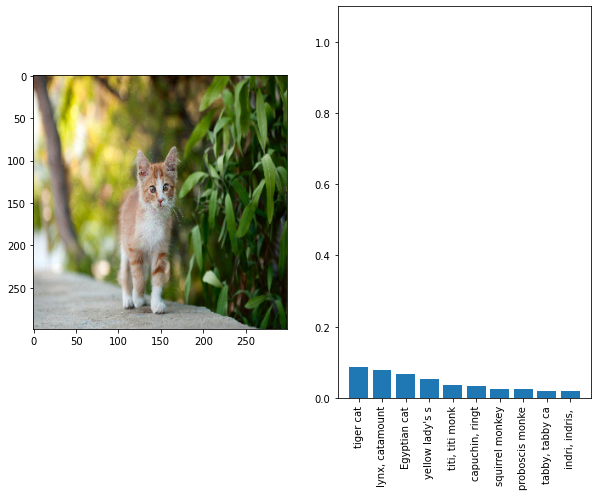

In [11]:
cropped_classify(adv, target_class=TARGET)

# Attack

Using EOT.

In [12]:
cropped_labels = tf.tile(tf.expand_dims(tf.one_hot(TARGET, 1000), axis=0), (cropped_logits.shape[0], 1))
cropped_xent = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=cropped_logits, labels=cropped_labels))
cropped_loss = cropped_xent + lam * normalized_l2_loss
cropped_grad, = tf.gradients(cropped_loss, x)

In [13]:
# PGD

LAM = 1.0
LR = 0.1

adv = np.copy(orig)
for i in range(50):
    g, l2, p = sess.run([cropped_grad, normalized_l2_loss, cropped_preds], {x: adv, lam: LAM, l2_x: adv, l2_orig: orig})
    if i % 10 == 0:
        print('step %d, l2=%f, preds=%s' % (i, l2, p))
    # step
    adv -= LR * g
    # project
    adv = np.clip(adv, 0, 1)

step 0, l2=0.000000, preds=[282 282 282 986 282 282 105  95  95  95 371  95 380 278 282 371 263 986
 156 287 282 285 280 282  95 986 986 986 282 287]
step 10, l2=0.000092, preds=[939 287 965 924 946 924 924 924 287 738 924 282 924 263 986 287 924 924
 282 924 924 282 924 287 924 287 924 924 924 263]
step 20, l2=0.000163, preds=[923 924 924 924 924 924 282 924 924 924 924 924 924 263 924 924 924 924
 924 924 924 924 924 937 924 924 924 924 924 924]
step 30, l2=0.000187, preds=[924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924
 924 924 924 924 924 924 924 924 924 924 939 924]
step 40, l2=0.000205, preds=[924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924
 924 924 924 924 924 924 924 924 924 924 924 924]


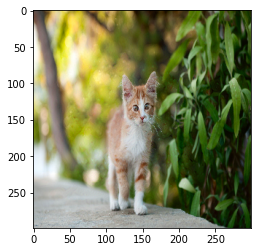

In [14]:
plt.imshow(adv)

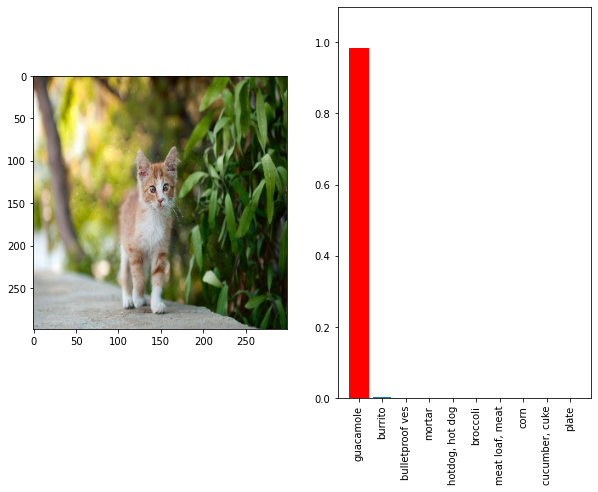

In [15]:
cropped_classify(adv, target_class=TARGET)

<a id='ablation'></a>
# <span style="color:red">Our New Ablation Study</span>

The above example uses the following parameters:

```
Learning Rate: 0.1
Gradient Descent Step: 50
EOT Samples: 30  (the default value for defend_crop() is 30)
```

Now, we change these parameters to:

```
Learning Rate: 0.01          # We use a smaller step size
Gradient Descent Step: 200   # We use more steps
EOT Samples: 1               # We disable EOT
```

**<span style="color:red">Below, we show that the new setting (without EOT) still breaks the defense.</span>**

We first reconstruct the computation graph with EOT = 1

In [16]:
# EOT = 1
cropped_xs = defend_crop(x, ensemble_size=1)
cropped_logits, cropped_preds = inceptionv3.model(sess, cropped_xs)

# Copied from above
cropped_labels = tf.tile(tf.expand_dims(tf.one_hot(TARGET, 1000), axis=0), (cropped_logits.shape[0], 1))
cropped_xent = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=cropped_logits, labels=cropped_labels))
cropped_loss = cropped_xent + lam * normalized_l2_loss
cropped_grad, = tf.gradients(cropped_loss, x)

And rerun the attack with 200 steps and LR = 0.01

In [18]:
# PGD
LAM = 1.0
LR = 0.01

adv = np.copy(orig)
for i in range(200):
    g, l2, p = sess.run([cropped_grad, normalized_l2_loss, cropped_preds], {x: adv, lam: LAM, l2_x: adv, l2_orig: orig})
    if i % 20 == 0:
        print('step %d, l2=%f, preds=%s' % (i, l2, p))
    # step
    adv -= LR * g
    # project
    adv = np.clip(adv, 0, 1)

step 0, l2=0.000000, preds=[95]
step 20, l2=0.000016, preds=[986]
step 40, l2=0.000054, preds=[373]
step 60, l2=0.000088, preds=[287]
step 80, l2=0.000128, preds=[988]
step 100, l2=0.000155, preds=[282]
step 120, l2=0.000196, preds=[287]
step 140, l2=0.000234, preds=[373]
step 160, l2=0.000269, preds=[924]
step 180, l2=0.000300, preds=[924]


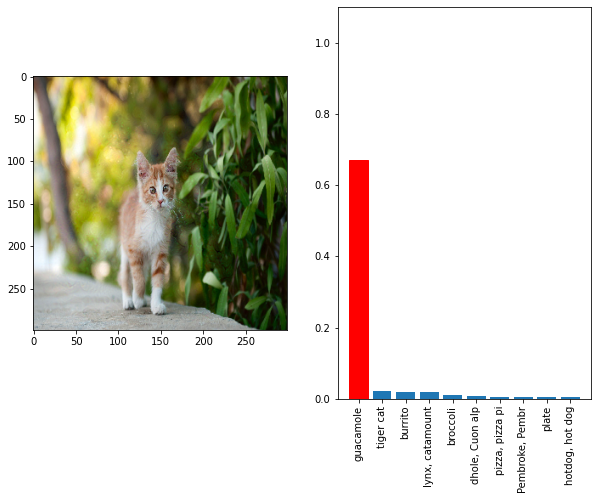

In [19]:
cropped_classify(adv, target_class=TARGET)